In [745]:
using JuMP, Ipopt, Plots
using Images, QuartzImageIO, ImageView

In [746]:
dynopt_sbr = Model(solver=IpoptSolver());

#### The following elementary chemical reaction:
$$ A + B \rightarrow C, \quad -r_A = K C_A C_B $$
#### takes place in an well-stirred isothermal semibatch reactor. As shown in the figure, initially 50 moles of reactant A are loaded into the reactor. The recorded initial volume turns out to be 250 L. The initial reactor load does not feature components B and C. Moreover, the concentration of the component B feed stream is 0.4 mol/L and initially 24 mol/h are fed to the reactor.

#### You are asked to compute the optimal volumetric flowrate profile of reactant B fed to the reactor such that maximum amount of product C is manufactured deploying the minimum amount of reactant B at minimum processing time.

In [747]:
img = load("fig1_sbr.png")

┌ Warning: QuartzImageIO created no image source
└ @ QuartzImageIO /Users/antonioflores/.julia/packages/QuartzImageIO/9DhKg/src/QuartzImageIO.jl:47


In [748]:
np       = 1:101
cbf      = 0.4      # mol/L
#fbf      = 0.4*60      # mol/min

ca_init  = 0.25 # mol/L
na_init  = 50   # mol
nb_init  = 0
nc_init  = 0
v_init   = na_init/ca_init # L
v_max     = 400 # L

a        = 2.5*60    # L/(mol-min)
e        = 2.8e03 # cal/mol
t        = 373.16 # K
rgas     = 1.987  # cal/(mol-K)
k        = a*exp(-e/(rgas*t))  # L/(mol-min)

t0       = 0  # min
tf       = 10 # min
alpha1   = 1;
alpha2   = 1;

In [749]:
time  = Array{Float64}(undef, length(np))
w     = Array{Float64}(undef, length(np))
dt    = (tf-t0)/(length(np)-1)
for i = 1:length(np)
   time[i] = t0+(i-1)*dt
end
w[1] = 1
w[length(np)] = 1;
for i = 2:length(np)-1
    w[i] = 2
    if mod(i,2) == 0
       w[i] = 3
    end
end

In [750]:
@variable(dynopt_sbr, 0      <= na[np]  <= na_init,    start = 0.5*na_init)
@variable(dynopt_sbr,           nb[np]  >= 0      ,    start = 0.5*na_init)
@variable(dynopt_sbr,           nc[np]  >= 0      ,    start = 0.5*na_init)
@variable(dynopt_sbr, v_init <= v[np]   <= v_max  ,    start = v_init     )
@variable(dynopt_sbr,      0 <= fbf[np] <= 100    ,    start = 50          );

In [751]:
@constraint(dynopt_sbr, icond_na, na[1] == na_init)
@constraint(dynopt_sbr, icond_nb, nb[1] == nb_init)
@constraint(dynopt_sbr, icond_nc, nc[1] == nc_init)
@constraint(dynopt_sbr, icond_v , v[1]  == v_init );
@constraint(dynopt_sbr, icond_fb, fbf[1] == 0.4*60 );

In [752]:
@NLconstraint(dynopt_sbr, dynmodel_na[i in 2:length(np)], 
  na[i] == na[i-1] + dt*( -k*(na[i]/v[i])*(nb[i]/v[i])*v[i] ) ) ;

In [753]:
@NLconstraint(dynopt_sbr, dynmodel_nb[i in 2:length(np)], 
  nb[i] == nb[i-1] + dt*( fbf[i] -k*(na[i]/v[i])*(nb[i]/v[i])*v[i] ) ) ;

In [754]:
@NLconstraint(dynopt_sbr, dynmodel_nc[i in 2:length(np)], 
  nc[i] == nc[i-1] + dt*( k*(na[i]/v[i])*(nb[i]/v[i])*v[i] ) ) ;

In [755]:
@NLconstraint(dynopt_sbr, dynmodel_v[i in 2:length(np)], 
  v[i] == v[i-1] + dt*( fbf[i]/cbf ) ) ;

In [756]:
@NLobjective(dynopt_sbr, Max, 
(dt/3)*sum(w[i]*( alpha1*(nc[i])^2 - alpha2*(nb[i]^2 )) for i in np   )  );

In [757]:
status_dynopt_sbr = solve(dynopt_sbr);

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1705
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2002

Total number of variables............................:      505
                     variables with only lower bounds:      202
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      405
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [758]:
println("Objective function value = ", getobjectivevalue(dynopt_sbr))

Objective function value = 6287.218407184031


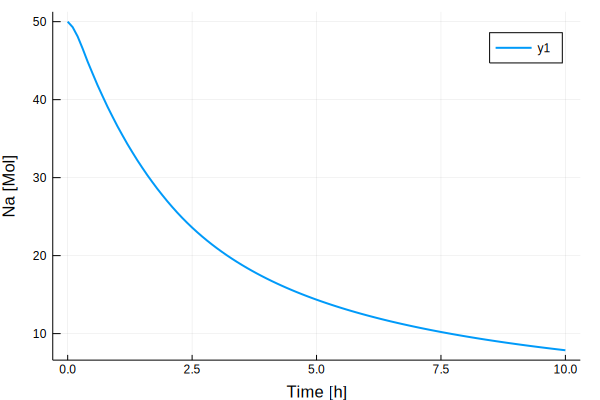

In [759]:
mytime   = Array{Float64}(undef, length(np))                
nap      = Array{Float64}(undef, length(np))                
nbp      = Array{Float64}(undef, length(np))                
ncp      = Array{Float64}(undef, length(np))                
vp       = Array{Float64}(undef, length(np)) 
fbfp     = Array{Float64}(undef, length(np))

for i = 1:length(np)
    mytime[i] = time[i]
    nap[i]  = getvalue(na[i])   
    nbp[i]  = getvalue(nb[i])   
    ncp[i]  = getvalue(nc[i])   
    vp[i]   = getvalue(v[i])
    fbfp[i] = getvalue(fbf[i])/cbf    
end    

plot(mytime,nap,lw=2,xlabel="Time [h]",ylabel="Na [Mol]")

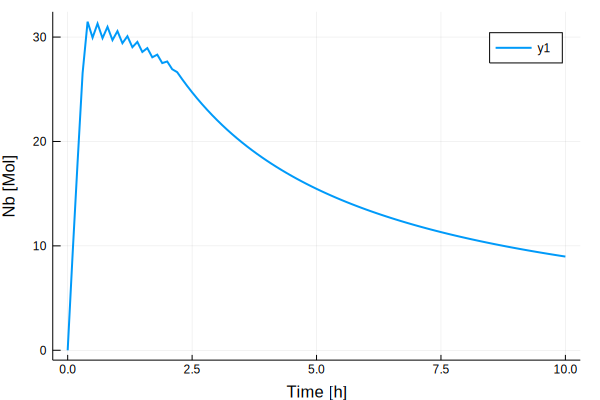

In [760]:
plot(mytime,nbp,lw=2,xlabel="Time [h]",ylabel="Nb  [Mol]")

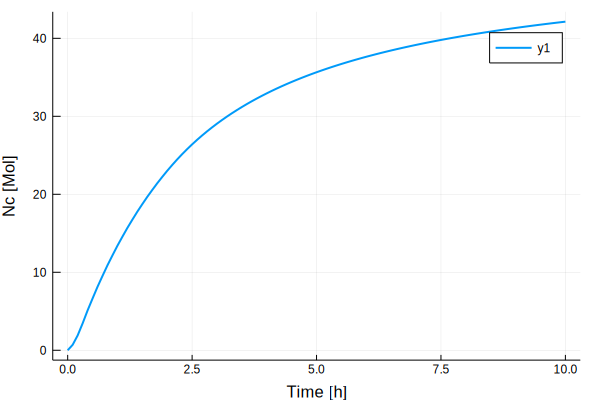

In [761]:
plot(mytime,ncp,lw=2,xlabel="Time [h]",ylabel="Nc  [Mol]")

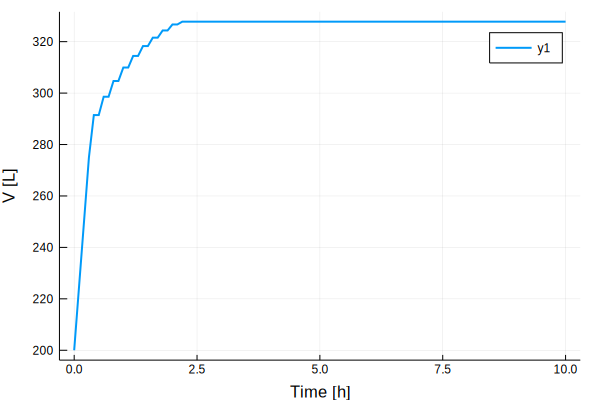

In [762]:
plot(mytime,vp,lw=2,xlabel="Time [h]",ylabel="V  [L]")

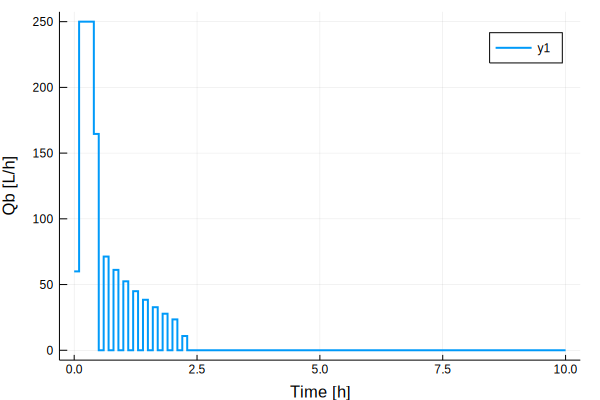

In [763]:
plot(mytime,fbfp,lw=2,linetype=:steppost,xlabel="Time [h]",ylabel="Qb [L/h]")